In [98]:
import pandas as pd
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
import math
from collections import namedtuple
from pathlib import Path
import os
Cluster = namedtuple('Point', 'x y z')#meant to convey x,y,z mean of cluster
#repopath = Path(__file__).parent
# fname = r'D:\ObstacleSegmentation\1636310276 - 4-3877 ms.txt'
#fname = r'1636310276 - 4-3877 ms.txt'
fname = r'1636468456 - 1-4789 ms.txt'
#file = os.path.join(repopath,fname)
#output = os.path.join(repopath,'beta_angles_' + fname)

#create pandas dataframe from asc file
df = pd.read_csv(fname,header=None,delimiter = ' ')

#rename the columns based on output from cloudcompare 
#df.columns =['x','y','z', 'dist','ang','time','r','g','b','empty']
df.columns = ['x', 'y', 'z', 'r', 'g', 'b', 'dist','ang', 'time']
#df = pd.read_csv('D:/ObstacleSegmentation/1636310276.7642572_LidarSensor1_pointcloud.asc')
npdf = df[['x','y','z']].to_numpy()

In [99]:
clustering = DBSCAN(eps=.5, min_samples=2).fit(npdf)

In [100]:
df['clusterfromdbscan'] = clustering.labels_ #add clusterfromdbscan column to df

In [101]:
cluster_centers=dict.fromkeys(df.clusterfromdbscan.unique())
for cluster in df.clusterfromdbscan.unique():  
    tempclusterseries = df[df['clusterfromdbscan']==cluster][['x', 'y', 'z']].agg('mean') #grabs all points associated with cluster in for loop step
    
    cluster_centers[cluster]= Cluster(tempclusterseries.x,tempclusterseries.y,tempclusterseries.z) #makes cluster series type into dict, 'cluster_centers.x,...'

In [102]:
#Associate clusters by neighborhood
cluster_center_array=pd.DataFrame.from_dict(cluster_centers,orient='index').to_numpy()
LIDAR_range=100
elevation_angle=(30*np.pi)/180
number_beams=16
raster_buffer=1.25 #25%
distance_between_raster_lines=LIDAR_range*np.tan(elevation_angle / number_beams)*raster_buffer
#print(distance_between_raster_lines)
neighborhood_clustering = DBSCAN(eps=distance_between_raster_lines, min_samples=2).fit(cluster_center_array)
neighborhood_clustering_variable = neighborhood_clustering.labels_

%matplotlib widget
#plt.title('number of points per neighborhood cluster')
#plt.hist(neighborhood_clustering.labels_)

In [103]:
neighborhoodclusters = pd.DataFrame(neighborhood_clustering.labels_)
neighborhoodclusters.columns = ['newcluster']
clustercenterdf = pd.DataFrame(cluster_center_array)

clustercenterdf = clustercenterdf.join(neighborhoodclusters)

#clustercenterdf.columns=['x','y','z','newcluster']

old2newclustermap = clustercenterdf.newcluster.to_dict()

df['neighborhoodcluster'] = df['clusterfromdbscan'].map(old2newclustermap)
df.describe()

x             y             z        r        g        b  \
count  68677.000000  68677.000000  68677.000000  68677.0  68677.0  68677.0   
mean      86.130166     -0.838024    -12.480897    255.0    255.0      0.0   
std        8.296174      3.273457      4.936450      0.0      0.0      0.0   
min       79.790642     -4.801706    -26.736063    255.0    255.0      0.0   
25%       81.545029     -2.802772    -15.914061    255.0    255.0      0.0   
50%       81.668198     -2.366756    -12.202532    255.0    255.0      0.0   
75%       83.627365     -0.648486     -8.968765    255.0    255.0      0.0   
max      103.411919      6.967259     -0.164448    255.0    255.0      0.0   

               dist           ang          time  clusterfromdbscan  \
count  68677.000000  68677.000000  68677.000000       68677.000000   
mean      84.374023      0.029061   2904.402478          13.583398   
std        7.966612      0.028623   1293.066038          20.604549   
min       76.390823      0.000000      1.000000           0.000000   
25%       79.203964      0.011025   2100.000000           2.000000   
50%       80.706779      0.024700   3053.000000           2.000000   
75%       84.129814      0.032896   3979.000000          22.000000   
max       99.991211      0.177302   4789.000000          89.000000   

       neighborhoodcluster  
count         68677.000000  
mean              0.239760  
std               0.445728  
min              -1.000000  
25%               0.000000  
50%               0.000000  
75%               0.000000  
max               2.000000

In [104]:
df[df['clusterfromdbscan']==cluster].describe()

x          y          z      r      g     b       dist  \
count   44.000000  44.000000  44.000000   44.0   44.0  44.0  44.000000   
mean   101.908524   4.378951  -9.373247  255.0  255.0   0.0  97.943394   
std      0.030207   0.052740   0.000054    0.0    0.0   0.0   0.027818   
min    101.878662   4.326814  -9.373300  255.0  255.0   0.0  97.915894   
25%    101.878662   4.326814  -9.373300  255.0  255.0   0.0  97.915894   
50%    101.908524   4.378951  -9.373247  255.0  255.0   0.0  97.943394   
75%    101.938385   4.431088  -9.373194  255.0  255.0   0.0  97.970894   
max    101.938385   4.431088  -9.373194  255.0  255.0   0.0  97.970894   

             ang         time  clusterfromdbscan  neighborhoodcluster  
count  44.000000    44.000000               44.0                 44.0  
mean    0.003265  4766.954545               89.0                  1.0  
std     0.000140    12.858722                0.0                  0.0  
min     0.003037  4745.000000               89.0                  1.0  
25%     0.003133  4756.000000               89.0                  1.0  
50%     0.003264  4767.000000               89.0                  1.0  
75%     0.003396  4778.000000               89.0                  1.0  
max     0.003497  4788.000000               89.0                  1.0

In [105]:
def specialangle(d0, theta0, d1, theta1):
    psi = np.abs(theta0 - theta1)
    num = d0 * np.sin(psi)
    den = (d0 - d1) * np.cos(psi)
    beta = np.arctan2(num,den)
    return beta

In [106]:
def calculate_center(thiscluster): #only consider x and y for intersection overlap algorithm, downstream from neighborhood clusters
    x_center = thiscluster.x.mean()
    y_center = thiscluster.y.mean()
    z_center = thiscluster.z.mean()
    x_std = thiscluster.x.std()
    y_std = thiscluster.y.std()
    rad = 2*max([x_std,y_std]) + 0.5
    return x_center,y_center,rad,z_center

In [107]:
def find_meanAngDist(thiscluster):
    mean_dist = thiscluster.dist.mean()
    mean_ang = thiscluster.ang.mean()
    return mean_dist, mean_ang

In [108]:
cluster_median=dict.fromkeys(df.clusterfromdbscan.unique())
for cluster in df.clusterfromdbscan.unique():  
    [dist, ang] = find_meanAngDist(df[df['clusterfromdbscan']==cluster]) #grabs all points associated with cluster in for loop step
    cluster_median[cluster]= [dist, ang]

In [109]:
cluster_mean_array=pd.DataFrame.from_dict(cluster_median,orient='index')
cluster_mean_array.columns=['dist','ang']
cluster_mean_array

dist       ang
0   81.541907  0.012233
1   80.193611  0.028367
2   79.766904  0.031976
3   84.141535  0.001356
4   98.334145  0.023700
..        ...       ...
85  99.169266  0.005272
86  99.983093  0.003254
87  99.626587  0.003254
88  89.543137  0.003259
89  97.943394  0.003265

[90 rows x 2 columns]

In [110]:
#return beta for each pair of clusters
ptlist = cluster_mean_array.index.to_list()
betadict = dict.fromkeys(ptlist) #dictionary for placeholder for everypoint
for idx1,pt1 in cluster_mean_array.iterrows(): #take current index
    betadict[idx1] = dict.fromkeys(ptlist) #make nested dictionary for every point (point 1 to every other one)
    for idx2,pt2 in cluster_mean_array.iterrows(): #looping thrugh every row, iterrrows returns row number and corresponding data
        betadict[idx1][idx2] = specialangle(pt1.dist, pt1.ang, pt2.dist, pt2.ang)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
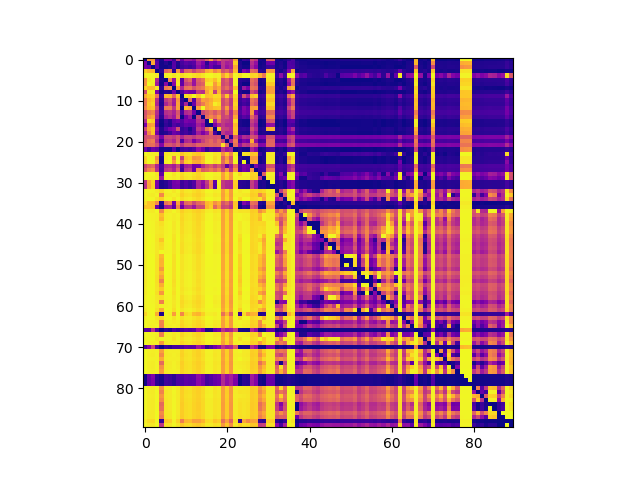

In [118]:
%matplotlib widget
data=pd.DataFrame(betadict).to_numpy()
plt.imshow(data, cmap='plasma', interpolation='nearest')

In [112]:
betadict

{0: {0: 0.0,
  1: 0.7731558792209036,
  2: 0.7367224715734915,
  3: 2.81277864745404,
  4: 3.085962827745371,
  5: 2.344790917759671,
  6: 2.3659227373621996,
  7: 2.8558070939041627,
  8: 1.6672942368326125,
  9: 2.5465207845555695,
  10: 2.0617932254494473,
  11: 2.0732664906696825,
  12: 2.242220477038406,
  13: 1.717221447709328,
  14: 1.776397967141893,
  15: 1.3033768092698723,
  16: 0.777455552554292,
  17: 1.6615764613531883,
  18: 1.200282141933215,
  19: 1.6489079742928687,
  20: 1.6752359801952847,
  21: 1.8190665483386563,
  22: 0.6616931977475089,
  23: 3.126416614851017,
  24: 2.8736028322970912,
  25: 2.9302306103506406,
  26: 1.5602403904393214,
  27: 1.7812240316116859,
  28: 3.081005358338955,
  29: 3.113992387823699,
  30: 1.3749831489109319,
  31: 1.329125246514329,
  32: 3.101146845519096,
  33: 3.1288463427531243,
  34: 3.078059016139108,
  35: 2.945252077673056,
  36: 2.737564987201328,
  37: 3.110252581918984,
  38: 3.1209675389261697,
  39: 3.120599883168509,
 

In [120]:
beta_bottom_thresh=.5
beta_top_thresh=1.1
closepointsdict = dict.fromkeys(ptlist) #use index to generate the keys
for point in betadict.keys(): #getting the keys to loop through every point
    ptsinrange = []
    for point2, beta in betadict[point].items(): #getting back point and associated overlap for every entry
        if beta > beta_bottom_thresh and beta < beta_top_thresh:
            ptsinrange.append(point2) #append to ptsinrange
    closepointsdict[point] = ptsinrange

In [125]:
closepointsdict

{0: [1, 2, 16, 22],
 1: [2, 70, 77, 78, 79],
 2: [22, 77, 78, 79],
 3: [1, 2, 6, 8, 15, 16, 17, 18, 30, 31, 36],
 4: [19, 21, 28, 29],
 5: [0, 6, 14, 36],
 6: [0, 17],
 7: [5, 6, 8, 11, 14, 15, 17, 18, 30, 31, 35, 36],
 8: [15, 18, 30, 31],
 9: [0, 3, 6, 35, 36],
 10: [0, 8, 14, 15, 16, 26, 70, 77, 78, 79],
 11: [0, 8, 14, 15, 16],
 12: [0, 5, 6, 8, 11, 13, 15, 16, 20, 26, 27, 36, 70, 77, 78, 79],
 13: [1, 2, 22, 26, 66, 70, 77, 78, 79],
 14: [1, 2, 16, 18, 22, 30, 31, 66, 70, 77, 78, 79],
 15: [18],
 16: [1, 2],
 17: [1, 16, 30, 66, 70, 77, 78, 79],
 18: [1, 66, 70, 77, 78, 79],
 19: [],
 20: [2, 22, 26, 66, 77, 78, 79],
 21: [],
 22: [77, 78, 79],
 23: [19, 21],
 24: [3, 7, 12, 13, 14, 20, 26, 27, 35],
 25: [3, 7, 12, 13, 20, 26, 27, 35],
 26: [77, 78, 79],
 27: [1, 2, 13, 16, 18, 20, 22, 26, 31, 66, 70, 77, 78, 79],
 28: [19, 21],
 29: [19, 21],
 30: [1, 16, 66, 70, 77, 78, 79],
 31: [1, 16, 66, 70, 77, 78, 79],
 32: [19, 21, 34, 47, 64, 67, 89],
 33: [4, 19, 21, 28, 29, 59, 64, 65,

In [121]:
def getadjacent(confirmedhits,pt2check,need2checkstill):
    # current code requires set to be closed (e.g. dictionary must not reference points that aren't in dictionary
    # if pt2check in testdict: 
    need2checkstill = need2checkstill | (set(closepointsdict[pt2check]) - confirmedhits) #union is operator look up closedpointsdict for the point to check 
    if len(need2checkstill) > 0:
        thispt = need2checkstill.pop()
        confirmedhits = confirmedhits | set([thispt]) #union is grouping everything together
        return getadjacent(confirmedhits,thispt,need2checkstill)
    else:
        return confirmedhits

In [122]:
adjacent_confirmed = set()
ungroupedpts = ptlist
need2checkstill = set()
neighbors = getadjacent(adjacent_confirmed,ungroupedpts[3],need2checkstill)
neighbors

{0, 1, 2, 6, 8, 15, 16, 17, 18, 22, 30, 31, 36, 66, 70, 77, 78, 79}

In [123]:
groupnum = 0
ungroupedpts = ptlist
print(ungroupedpts)
clusters_dict = {}
while len(ungroupedpts) > 0:
    adjacent_confirmed = set()
    need2checkstill = set()
    neighbors = getadjacent(adjacent_confirmed,ungroupedpts[0],need2checkstill)
    clusters_dict[groupnum] = neighbors
    if len(neighbors)==0:
        neighbors = [ungroupedpts[0]]
    print(neighbors)
    ungroupedpts = list(set(ungroupedpts) - set(neighbors))
    groupnum+=1

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]
{1, 2, 66, 70, 77, 78, 79, 16, 22}
{1, 2, 66, 70, 77, 78, 79, 16, 22}
{1, 2, 66, 70, 77, 78, 79, 16, 22}
{1, 2, 66, 70, 77, 78, 79, 16, 22}
{1, 2, 66, 70, 77, 78, 79, 16, 22}
{1, 2, 66, 70, 77, 78, 79, 16, 22}
{1, 2, 66, 70, 77, 78, 79, 16, 22}
{1, 2, 66, 70, 77, 78, 79, 16, 22}
{1, 2, 66, 70, 77, 78, 79, 16, 22}
{1, 2, 66, 70, 77, 78, 79, 16, 22}
{1, 2, 66, 70, 77, 78, 79, 16, 22}
{1, 2, 66, 70, 77, 78, 79, 16, 22}
{1, 2, 66, 70, 77, 78, 79, 16, 22}
{1, 2, 66, 70, 77, 78, 79, 16, 22}
{1, 2, 66, 70, 77, 78, 79, 16, 22}
{1, 2, 66, 70, 77, 78, 79, 16, 22}
{1, 2, 66, 70, 77, 78, 79, 16, 22}
{1, 2, 66, 70, 77, 78, 79, 16, 22}
{1, 2, 66, 70, 77, 

KeyboardInterrupt: 

KeyboardInterrupt: 

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
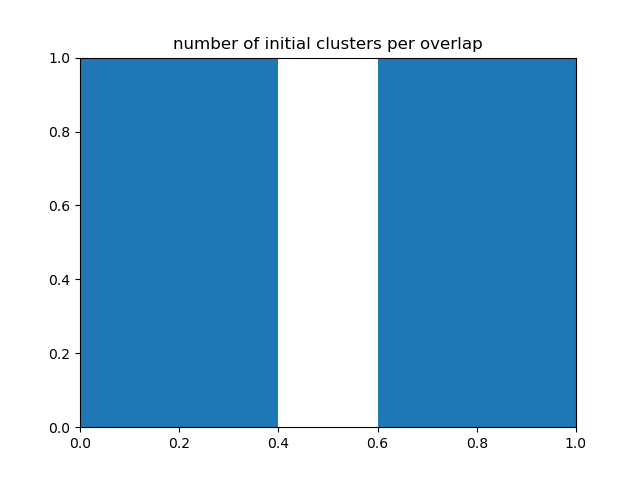

In [124]:
%matplotlib widget
plt.title('number of initial clusters per overlap')
plt.bar(clusters_dict.keys(),[len(v) for k,v in clusters_dict.items()])